# 📓 Notebook 02: Model Training

## Short description of the notebook

# 📚 Dependencies

In [67]:
# Install missing packages (Colab only)
!pip install -q sktime pykalman


In [74]:
# === Standard Library ===
import os
import sys
import warnings
import random
import logging
import pickle
import re
from pathlib import Path
from typing import List, Optional, Union, Dict, Tuple, Generator
from dataclasses import dataclass, field

# === Third-Party Libraries ===

## Scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Scikit-learn
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## sktime (for time series splits)
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter

## Kalman filter
from pykalman import KalmanFilter

# === Serialization ===
import joblib


from dataclasses import dataclass, field
import pandas as pd
import numpy as np
from typing import Optional, Dict, Any
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Optional
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display as ipy_display
from typing import Optional, List


# 🌐 General Setup

In [41]:
%%bash
cd /content

REPO=https://github.com/jacopo-raffaeli/portfolio-replica.git
DIR=portfolio-replica

# Clone if needed, else pull latest
if [ ! -d "$DIR" ]; then
  git clone $REPO > /dev/null 2>&1
else
  cd $DIR
  git pull origin main > /dev/null 2>&1
  cd ..
fi

# Enter project root and install dependencies
cd $DIR
pip install -r requirements.txt > /dev/null 2>&1


In [42]:
# Add repo root to sys.path for imports
PROJECT_ROOT = "/content/portfolio-replica"
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    sys.path.append(os.path.join(PROJECT_ROOT, 'src'))

# Set working directory for relative paths
os.chdir(PROJECT_ROOT)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/portfolio-replica


In [43]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 3)

# Seaborn and Matplotlib display options
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Set reproducible seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S'
)
logger = logging.getLogger(__name__)

# Define paths
data_raw_path = "data/raw/"
data_interim_path = "data/interim/"
data_processed_path = "data/processed/"

# 🛠 Utilities

## Load & Prepare data

In [76]:
def compute_index_returns(
    df_idx: pd.DataFrame,
    index_weights: Dict[str, float] = None
) -> pd.Series:
    """
    Compute weighted composite index returns from raw index price levels.

    Parameters
    ----------
    df_idx : pd.DataFrame
        DataFrame of index price levels (columns are index names).
    index_weights : dict, optional
        Mapping from index column to weight. If None, uses equal weights.

    Returns
    -------
    y : pd.Series
        Composite index returns.
    """
    # Determine which indices to use
    cols = df_idx.columns.tolist()
    if index_weights is None:
        # Equal weights if not provided
        index_weights = {col: 1.0 / len(cols) for col in cols}
    else:
        # Validate provided keys
        missing = set(index_weights) - set(cols)
        if missing:
            raise KeyError(f"Index weights refer to unknown columns: {missing}")

    # Compute simple returns
    ret = df_idx[list(index_weights.keys())].pct_change(fill_method=None).dropna()

    # Apply weights
    weighted = pd.DataFrame({col: ret[col] * weight
                             for col, weight in index_weights.items()},
                            index=ret.index)

    # Sum to get composite
    y = weighted.sum(axis=1)
    y.name = "Target_Index"
    return y

def compute_futures_returns(
    df_fut: pd.DataFrame
) -> pd.DataFrame:
    """
    Compute returns for futures price levels.

    Parameters
    ----------
    df_fut : pd.DataFrame
        DataFrame of futures price levels (columns are futures names).

    Returns
    -------
    X : pd.DataFrame
        Futures returns DataFrame.
    """
    X = df_fut.pct_change(fill_method=None).dropna()
    return X

def align_features_target(
    X: pd.DataFrame,
    y: pd.Series
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Align feature and target on common datetime index.

    Parameters
    ----------
    X : pd.DataFrame
        Feature returns with datetime index.
    y : pd.Series
        Target returns with datetime index.

    Returns
    -------
    X_aligned : pd.DataFrame
    y_aligned : pd.Series
        Subsets of X and y sharing the same index.
    """
    common_idx = X.index.intersection(y.index)
    X_aligned = X.loc[common_idx]
    y_aligned = y.loc[common_idx]
    return X_aligned, y_aligned

def prepare_X_y(
    df_indices: pd.DataFrame,
    df_futures: pd.DataFrame,
    index_weights: Dict[str, float] = None
) -> Tuple[pd.DataFrame, pd.Series]:
    """
    High-level wrapper: compute and align index and futures returns.

    Parameters
    ----------
    df_indices : pd.DataFrame
        Raw index price levels.
    df_futures : pd.DataFrame
        Raw futures price levels.
    index_weights : dict, optional
        Composite index weights. Default: equal weights.

    Returns
    -------
    X, y : aligned returns ready for modeling
    """
    y = compute_index_returns(df_indices, index_weights=index_weights)
    X = compute_futures_returns(df_futures)
    X_aligned, y_aligned = align_features_target(X, y)
    return X_aligned, y_aligned


## Split Data

In [77]:
def generate_backtest_splits(
    y: pd.Series,
    strategy: str = "sliding",
    window_length: int = 52,
    step_length: int = 1
) -> Generator[Tuple[pd.Index, pd.Index], None, None]:
    """
    One-step-ahead backtest splits for replication.

    At each fold:
      - Train on `window_length` points (or all past for expanding)
      - Test on the single point immediately after that window (t+1)

    Parameters
    ----------
    y : pd.Series
        Target series (index only used for length).
    strategy : {'sliding', 'expanding'}
        'sliding'   → fixed-size rolling window of length `window_length`.
        'expanding' → growing window that starts at size `window_length` and then increases.
    window_length : int
        For 'sliding': # samples in each train window.
        For 'expanding': # samples in initial train window.
    step_length : int
        How many periods to move forward between fits.

    Yields
    ------
    train_idx : np.ndarray
        Integer positions for training (length = window_length or growing).
    test_idx : np.ndarray
        Single-element array containing the one-step-ahead index.
    """
    # always one-step ahead
    fh = [1]
    if strategy == "sliding":
        splitter = SlidingWindowSplitter(
            window_length=window_length,
            step_length=step_length,
            fh=fh
        )
    elif strategy == "expanding":
        splitter = ExpandingWindowSplitter(
            initial_window=window_length,
            step_length=step_length,
            fh=fh
        )
    else:
        raise ValueError(f"Unknown strategy '{strategy}'")

    for train_idx, test_idx in splitter.split(y):
        yield train_idx, test_idx


## Simulate Backtest

In [78]:
def prepare_data(X, y, train_idx, test_idx):
    """
    Extract training and test sets for a single backtest iteration.

    Returns:
        X_train, y_train: training features and target
        X_next, y_next: test features and target (next step)
        date_next: date/index of test step
    """
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_next = X.iloc[test_idx].values.flatten()
    y_next = y.iloc[test_idx].iloc[0]
    date_next = y.index[test_idx][0]
    return X_train, y_train, X_next, y_next, date_next


In [79]:
def train_model(build_model, model_params, X_train, y_train):
    """
    Build and fit model pipeline on training data.
    """
    model = build_model(**model_params)
    model.fit(X_train, y_train)
    return model


In [80]:
def unscale_weights(model):
    """
    Extract model weights and unscale them if scaler present.

    Returns:
        original_weights: scaled-back portfolio weights
        scale: scaling factors from scaler or ones
    """
    scaler = model.named_steps.get('scaler', None)
    reg = model.named_steps['regressor']
    normalized_weights = reg.coef_.copy()
    if scaler is not None and hasattr(scaler, 'scale_'):
        scale = scaler.scale_
        original_weights = normalized_weights / scale
    else:
        scale = np.ones_like(normalized_weights)
        original_weights = normalized_weights.copy()
    return original_weights, scale


In [81]:
def simulate_backtest_regression(
    X,
    y,
    splitter,
    build_model,
    model_params,
    constraint_funcs=None,
    constraint_params=None,
    transaction_cost_rate=0.0,
    scaler_name="standard",
    verbose=False
):
    """
    Run one-step-ahead replication backtest for regression models.

    Returns BacktestResult with weights, returns, metrics, etc.
    """
    constraint_params = constraint_params or {}

    # Initialize records
    scale_history = []
    weights_history = []
    gross_exposures = []
    replica_returns_gross = []
    replica_returns_net = []
    target_returns = []
    transaction_costs = []
    raw_weights_history = []
    portfolio_turnovers = []
    dates = []

    # Initialize constraints history
    constraints_history = {fn.__name__: [] for fn in constraint_funcs} if constraint_funcs else {}

    for step_num, (train_idx, test_idx) in enumerate(splitter):
        # Prepare data
        X_train, y_train, X_next, y_next, date_next = prepare_data(X, y, train_idx, test_idx)

        if verbose:
            print(f"Step {step_num+1}: Training model on {len(train_idx)} samples — predicting for {date_next.date()}")

        # Train model
        model = train_model(build_model, model_params, X_train, y_train)

        # Get weights and scale factor
        original_weights, scale = unscale_weights(model)
        raw_weights_history.append(original_weights)

        # Apply constraints
        original_weights = apply_constraints(
            original_weights,
            constraint_funcs=constraint_funcs,
            prev_weights=weights_history,
            prev_returns=replica_returns_net,
            constraints_history=constraints_history,
            constraint_params=constraint_params
        )

        # Transaction cost
        prev_w = weights_history[-1] if weights_history else None
        transaction_cost, turnover = compute_transaction_cost(
            current_weights=original_weights,
            previous_weights=prev_w,
            cost_rate=transaction_cost_rate
        )

        # Step metrics
        replica_return_gross, replica_return_net, gross_exposure = compute_step_metrics(X_next, original_weights, transaction_cost)

        # Record
        scale_history.append(scale)
        weights_history.append(original_weights)
        gross_exposures.append(gross_exposure)
        replica_returns_gross.append(replica_return_gross)
        replica_returns_net.append(replica_return_net)
        target_returns.append(y_next)
        transaction_costs.append(transaction_cost)
        portfolio_turnovers.append(turnover)
        dates.append(date_next)

    # Final series
    weights_history = np.vstack(weights_history)
    raw_weights_history = np.vstack(raw_weights_history)
    replica_returns_gross = pd.Series(replica_returns_gross, index=dates, name='replica_returns')
    replica_returns_net = pd.Series(replica_returns_net, index=dates, name='replica_returns')
    target_returns = pd.Series(target_returns, index=dates, name='target_returns')
    transaction_costs=pd.Series(transaction_costs, index=dates)
    portfolio_turnovers=pd.Series(portfolio_turnovers, index=dates)

    # Aggregate metrics
    aggregate_metrics = compute_aggregate_metrics(
        target_returns=target_returns,
        replica_returns=replica_returns_net,
        gross_exposures=gross_exposures,
        scaling_factors=scale_history,
        weights_history=weights_history,
        config_params=model_params,
    )

    return BacktestResult(
        model_name=model.__class__.__name__,
        model_params=model_params,
        weights_history=weights_history,
        raw_weights_history=raw_weights_history,
        gross_exposures=gross_exposures,
        scale_history=scale_history,
        replica_returns=replica_returns_net,
        replica_returns_gross=replica_returns_gross,
        target_returns=target_returns,
        transaction_costs=transaction_costs,
        portfolio_turnovers=portfolio_turnovers,
        aggregate_metrics=aggregate_metrics,
        constraints_history=constraints_history,
        asset_names=X.columns.tolist(),
    )


In [82]:
def simulate_backtest_kalman(
    X, y, splitter, model_params,
    constraint_funcs=None,
    constraint_params=None,
    transaction_cost_rate=0.0,
    verbose=False
):
    """
    Run one-step-ahead replication backtest using a Kalman filter
    for dynamic weight estimation.
    """
    constraint_params = constraint_params or {}

    # Initialize histories
    scale_history = []
    weights_history = []
    gross_exposures = []
    replica_returns_gross = []
    replica_returns_net = []
    target_returns = []
    transaction_costs = []
    raw_weights_history = []
    portfolio_turnovers = []
    dates = []

    # Initialize constraints history
    constraints_history = {fn.__name__: [] for fn in constraint_funcs} if constraint_funcs else {}

    # Extract dimensions
    n_assets = X.shape[1]

    # Kalman model parameters
    trans_cov  = model_params.get("trans_cov", 1e-5)
    obs_cov    = model_params.get("obs_cov", 1e-2)
    init_scale = model_params.get("init_scale", 1e-3)

    # Initial regressor parameters
    init_with_regression = model_params.get("init_with_regression", False)
    regressor_cls = model_params.get("regressor_cls", None)
    regressor_params = model_params.get("regressor_params", {})

    # Initialize Kalman filter
    kf = KalmanFilter(
        transition_matrices      = np.eye(n_assets),
        observation_matrices     = None,
        transition_covariance    = trans_cov * np.eye(n_assets),
        observation_covariance   = obs_cov,
        initial_state_mean       = np.zeros(n_assets),
        initial_state_covariance = init_scale * np.eye(n_assets)
    )

    # Initialize Kalman state
    state_mean = np.zeros(n_assets)
    state_cov  = init_scale * np.eye(n_assets)

    for step_num, (train_idx, test_idx) in enumerate(splitter):
        # Per-step data
        X_train, y_train, X_next, y_next, date_next = prepare_data(X, y, train_idx, test_idx)

        if verbose:
            print(f"Step {step_num+1}: Kalman updating on {date_next.date()}")

        # Use only last observation in train set to update
        x_t = X_train.iloc[-1].values
        y_t = float(y_train.iloc[-1])

        # Weight initialization with regressor
        if init_with_regression and step_num == 0:
            if regressor_cls is None:
                raise ValueError("To use init_with_regression=True, you must provide regressor_cls.")

            if verbose:
                print(f"Initializing Kalman weights with {regressor_cls.__name__} on window ending {date_next.date()}")

            reg = regressor_cls(**(regressor_params or {}))
            reg.fit(X_train, y_train)
            init_weights = reg.coef_

            # Override initial state mean
            state_mean = init_weights.copy()

        # Kalman update step
        state_mean, state_cov = kf.filter_update(
            filtered_state_mean       = state_mean,
            filtered_state_covariance = state_cov,
            observation               = y_t,
            observation_matrix        = x_t[np.newaxis, :]
        )

        original_weights = state_mean.copy()
        raw_weights_history.append(original_weights)
        scale = None  # not applicable in Kalman

        # Apply constraints
        original_weights = apply_constraints(
            original_weights,
            constraint_funcs=constraint_funcs,
            prev_weights=weights_history,
            prev_returns=replica_returns_net,
            constraints_history=constraints_history,
            constraint_params=constraint_params
        )

        # Transcation cost
        prev_w = weights_history[-1] if weights_history else None
        transaction_cost, turnover = compute_transaction_cost(
            current_weights=original_weights,
            previous_weights=prev_w,
            cost_rate=transaction_cost_rate
        )

        # Step metrics
        replica_return_gross, replica_return_net, gross_exposure = compute_step_metrics(X_next, original_weights, transaction_cost)

        # Record
        scale_history.append(scale)
        weights_history.append(original_weights)
        gross_exposures.append(gross_exposure)
        replica_returns_gross.append(replica_return_gross)
        replica_returns_net.append(replica_return_net)
        target_returns.append(y_next)
        transaction_costs.append(transaction_cost)
        portfolio_turnovers.append(turnover)
        dates.append(date_next)

    # Final time-series
    weights_history = np.vstack(weights_history)
    raw_weights_history = np.vstack(raw_weights_history)
    replica_returns_gross = pd.Series(replica_returns_gross, index=dates, name='replica_returns')
    replica_returns_net = pd.Series(replica_returns_net, index=dates, name='replica_returns')
    target_returns = pd.Series(target_returns, index=dates, name='target_returns')
    transaction_costs=pd.Series(transaction_costs, index=dates)
    portfolio_turnovers=pd.Series(portfolio_turnovers, index=dates)



    # Aggregate metrics
    aggregate_metrics = compute_aggregate_metrics(
        target_returns=target_returns,
        replica_returns=replica_returns_net,
        gross_exposures=gross_exposures,
        scaling_factors=scale_history,
        weights_history=weights_history,
        config_params=model_params,
    )

    return BacktestResult(
        model_name="Kalman",
        model_params=model_params,
        weights_history=weights_history,
        raw_weights_history=raw_weights_history,
        gross_exposures=gross_exposures,
        scale_history=scale_history,
        replica_returns=replica_returns_net,
        replica_returns_gross=replica_returns_gross,
        transaction_costs=transaction_costs,
        portfolio_turnovers=portfolio_turnovers,
        target_returns=target_returns,
        aggregate_metrics=aggregate_metrics,
        constraints_history=constraints_history,
        asset_names=X.columns.tolist(),
    )


In [83]:
@dataclass
class BacktestResult:
    model_name: str
    model_params: Dict[str, Any]

    # Core performance time series
    target_returns: pd.Series
    replica_returns: pd.Series
    replica_returns_gross: Optional[pd.Series] = None
    transaction_costs: Optional[pd.Series] = None
    portfolio_turnovers: Optional[pd.Series] = None

    # Weights & scale tracking
    weights_history: np.ndarray = field(default_factory=lambda: np.empty((0, 0)))
    raw_weights_history: Optional[np.ndarray] = None
    scale_history: Optional[list] = None
    gross_exposures: Optional[list] = None

    # Aggregate metrics
    aggregate_metrics: Optional[Dict[str, Any]] = None

    # Constraints (optional)
    constraints_history: Optional[Dict[str, list]] = None

    # Add asset names list here
    asset_names: Optional[List[str]] = None

    def to_dict(self):
        return {
            "model_name": self.model_name,
            "model_params": self.model_params,
            "aggregate_metrics": self.aggregate_metrics,
            "constraints_history": self.constraints_history,
            "shape": {
                "weights": self.weights_history.shape,
                "returns": self.replica_returns.shape,
            },
            "asset_names": self.asset_names,
        }

    def summary(self):
        print(f"Model: {self.model_name}")
        print(f"Parameters: {self.model_params}")
        print(f"Length: {len(self.replica_returns)} steps")
        if self.aggregate_metrics:
            print(f"Sharpe: {self.aggregate_metrics.get('replica_sharpe'):.3f}, TE: {self.aggregate_metrics.get('tracking_error'):.4f}")


## Constraints

In [84]:
def apply_constraints(
    original_weights,
    constraint_funcs=None,
    prev_weights=None,
    prev_returns=None,
    constraints_history=None,
    constraint_params=None,
):
    """
    Apply each constraint function in order, modifying weights as needed.

    Parameters
    ----------
    original_weights : np.ndarray
        Proposed weights before constraints.
    constraint_funcs : list of callables
        Constraint functions, each taking (weights, weights_history, returns, **params).
    prev_weights : list of np.ndarray
        History of weights.
    prev_returns : list of float
        History of past returns.
    constraints_history : dict
        Dict to store metadata for each constraint.
    constraint_params : dict
        Dict mapping constraint function names to parameter dicts.
    """
    constraint_params = constraint_params or {}
    constraints_history = constraints_history or {}

    if constraint_funcs:
        for fn in constraint_funcs:
            fn_name = fn.__name__
            fn_params = constraint_params.get(fn_name, {})

            # Call constraint function with injected params
            original_weights, metadata = fn(
                original_weights,
                prev_weights,
                prev_returns,
                **fn_params
            )

            # Store metadata
            if constraints_history is not None:
                if fn_name not in constraints_history:
                    constraints_history[fn_name] = []
                constraints_history[fn_name].append(metadata)

    return original_weights


In [85]:
def constraint_gross_exposure(weights, weights_history, replica_returns, max_gross=2):
    gross = np.sum(np.abs(weights))
    metadata = {
        'activated': False,
        'violation_amount': 0.0,
        'rescaling_factor': 1.0,
        'gross_exposure': gross
    }
    if gross > max_gross:
        metadata['activated'] = True
        metadata['violation_amount'] = gross - max_gross
        rescale = max_gross / gross
        weights = weights * rescale
        metadata['rescaling_factor'] = rescale
    return weights, metadata


In [86]:
def calculate_var(returns, method: str, confidence: float = 0.01, horizon: int = 4) -> float:
    """
    Calculate Value at Risk (VaR) over a given time horizon.

    Parameters
    ----------
    returns : array-like
        Historical returns (e.g. weekly P&L series).
    method : {'gaussian', 'historical', 'cornish-fisher'}
        VaR calculation method.
    confidence : float
        Tail probability (e.g. 0.01 for 1% VaR).
    horizon : int
        Time horizon (in same units as returns, e.g. weeks).

    Returns
    -------
    var : float
        Positive number representing the loss at the given confidence/day horizon.
    """
    r = np.asarray(returns)
    if method == 'gaussian':
        mu, sigma = np.mean(r), np.std(r)
        # z for one-sided quantile
        z = abs(np.percentile(np.random.standard_normal(10_000), confidence * 100))
        var = -(mu + z * sigma) * np.sqrt(horizon)
    elif method == 'historical':
        # empirical quantile (these returns are negative if losses)
        hist_q = np.percentile(r, confidence * 100)
        var = -hist_q * np.sqrt(horizon)
    else:
        raise ValueError(f"Unknown VaR method '{method}'")
    return var

def constraint_var_historical(
    weights: np.ndarray,
    weights_history: list,
    replica_returns: list,
    max_var: float = 0.2,
    var_confidence: float = 0.01,
    var_horizon: int = 4,
    lookback: int = 20
) -> tuple[np.ndarray, dict]:
    """
    Project weights to satisfy a maximum historical VaR constraint.

    Parameters
    ----------
    weights : np.ndarray
        Proposed portfolio weights.
    weights_history : list of np.ndarray
        Past weights (unused here).
    replica_returns : list of float
        Past one-step replica returns.
    max_var : float
        Maximum allowed VaR (positive number).
    var_confidence : float
        Tail probability for VaR (e.g. 0.01 for 1%).
    var_horizon : int
        Horizon over which to scale VaR (e.g. 4 weeks).
    lookback : int
        Number of past returns to use for historical simulation.

    Returns
    -------
    new_weights, metadata : (np.ndarray, dict)
        Possibly rescaled weights and a metadata dict describing the adjustment.
    """
    metadata = {
        'activated': False,
        'estimated_var': np.nan,
        'violation': 0.0,
        'rescale_factor': 1.0
    }
    if len(replica_returns) < lookback:
        # Not enough history to estimate VaR
        return weights, metadata

    hist = replica_returns[-lookback:]
    est_var = calculate_var(hist, method='historical', confidence=var_confidence, horizon=var_horizon)
    metadata['estimated_var'] = est_var

    if est_var > max_var:
        metadata['activated'] = True
        metadata['violation'] = est_var - max_var
        factor = max_var / est_var
        weights = weights * factor
        metadata['rescale_factor'] = factor

    return weights, metadata


In [87]:
def constraint_turnover_band(
    weights: np.ndarray,
    weights_history: list,
    replica_returns: list,
    min_turnover: float = 0.02,
    max_turnover: float = 0.10
) -> tuple[np.ndarray, dict]:
    """
    Enforce both a minimum no-trade threshold and a maximum turnover cap.

    Parameters
    ----------
    weights : np.ndarray
        Proposed new weights.
    weights_history : list of np.ndarray
        Past weights; last entry is w_{t-1}.
    replica_returns : list
        Past returns (unused here).
    min_turnover : float
        Below this turnover, skip rebalancing entirely (no-trade band).
    max_turnover : float
        Above this turnover, scale changes down to this level.

    Returns
    -------
    new_weights, metadata : (np.ndarray, dict)
    """
    metadata = {
        'activated_min': False,
        'activated_max': False,
        'turnover': 0.0,
        'viol_min': 0.0,
        'viol_max': 0.0,
        'rescale_factor': 1.0
    }
    if not weights_history:
        return weights, metadata

    prev = weights_history[-1]
    turnover = np.sum(np.abs(weights - prev))
    metadata['turnover'] = turnover

    # No-trade band
    if turnover < min_turnover:
        metadata['activated_min'] = True
        metadata['viol_min'] = min_turnover - turnover
        return prev.copy(), metadata  # stay at old weights

    # Max-turnover cap
    if turnover > max_turnover:
        metadata['activated_max'] = True
        metadata['viol_max'] = turnover - max_turnover
        factor = max_turnover / turnover
        weights = prev + factor * (weights - prev)
        metadata['rescale_factor'] = factor

    return weights, metadata


## Transaction costs

In [88]:
def compute_transaction_cost(
    current_weights: np.ndarray,
    previous_weights: Optional[np.ndarray] = None,
    cost_rate: float = 0.0004
) -> float:
    """
    Compute round‑trip transaction cost based on turnover.

    Parameters
    ----------
    current_weights : np.ndarray
        New portfolio weights w_t.
    previous_weights : np.ndarray or None
        Prior portfolio weights w_{t-1}. If None, assumed zero (initial alloc).
    cost_rate : float
        Round‑trip cost per unit turnover (e.g. 0.0004 for 4 bps).

    Returns
    -------
    cost : float
        Transaction cost to be subtracted from portfolio return.
    """
    if previous_weights is None:
        prev = np.zeros_like(current_weights)
    else:
        prev = previous_weights
    turnover = np.sum(np.abs(current_weights - prev))
    return turnover * cost_rate, turnover


## Metrics


In [89]:
def compute_step_metrics(X_next, original_weights, transaction_cost):
    """
    Compute per-step metrics.
    """
    replica_return_gross = float(np.dot(X_next, original_weights))
    replica_return_net = replica_return_gross - transaction_cost
    gross_exposure = np.sum(np.abs(original_weights))
    return replica_return_gross, replica_return_net, gross_exposure


In [90]:
def compute_aggregate_metrics(
    target_returns: pd.Series,
    replica_returns: pd.Series,
    gross_exposures: list,
    scaling_factors: list,
    weights_history: list,
    config_params: dict
) -> dict:
    """Compute overall evaluation metrics for backtest."""
    # Compute cumulative returns for both target and replica
    cumulative_target = (1 + target_returns).cumprod()
    cumulative_replica = (1 + replica_returns).cumprod()

    # Annualized return and volatility
    target_mean_return = target_returns.mean() * 52
    replica_mean_return = replica_returns.mean() * 52
    target_vol = target_returns.std() * np.sqrt(52)
    replica_vol = replica_returns.std() * np.sqrt(52)

    # Sharpe ratio
    target_sharpe = target_mean_return / target_vol if target_vol > 0 else np.nan
    replica_sharpe = replica_mean_return / replica_vol if replica_vol > 0 else np.nan

    # Drawdons
    target_drawdown = 1 - cumulative_target / cumulative_target.cummax()
    replica_drawdown = 1 - cumulative_replica / cumulative_replica.cummax()

    # TE, IR, Corr
    tracking_error = (replica_returns - target_returns).std() * np.sqrt(52)
    information_ratio = (replica_mean_return - target_mean_return) / tracking_error if tracking_error > 0 else np.nan
    correlation = replica_returns.corr(target_returns)

    return {
        **config_params,
        'target_returns': target_returns,
        'replica_returns': replica_returns,
        'cumulative_target': cumulative_target,
        'cumulative_replica': cumulative_replica,
        'target_mean_return': target_mean_return,
        'replica_mean_return': replica_mean_return,
        'target_vol': target_vol,
        'replica_vol': replica_vol,
        'target_sharpe': target_sharpe,
        'replica_sharpe': replica_sharpe,
        'target_drawdowns': target_drawdown,
        'replica_drawdowns': replica_drawdown,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio,
        'correlation': correlation,
        'gross_exposures': gross_exposures,
        'avg_gross_exposure': np.mean(gross_exposures),
        'scaling_factors': scaling_factors,
        'weights_history': weights_history
    }


## Experiments

In [91]:
def run_single_backtest_experiment(config: dict) -> BacktestResult:
    """
    Run a backtest experiment from a unified configuration dictionary.

    Supports both regression-based and Kalman filter-based models.

    Expected keys in config:
    ...
    """
    model_name = config['model_name'].lower()

    # Filter relevant parameters for the selected model
    raw_model_params = config.get('model_params', {})
    model_params = filter_model_params(model_name, raw_model_params, verbose=config.get("verbose", False))

    # Create backtest splits
    splitter = generate_backtest_splits(
        y=config['y'],
        strategy=config.get('split_strategy', 'sliding'),
        window_length=config['window'],
        step_length=config['step']
    )

    # Kalman model
    if model_name == 'kalman':
        return simulate_backtest_kalman(
            X=config['X'],
            y=config['y'],
            splitter=splitter,
            model_params=model_params,
            constraint_funcs=config.get('constraint_funcs', None),
            constraint_params=config.get('constraint_params', {}),
            transaction_cost_rate=config.get("transaction_cost_rate", 0.0),
            verbose=config.get("verbose", False),
        )

    # Regressor model
    build_model = lambda **p: get_model(model_name, scaler_name=config.get("scaler_name", "standard"), **p)
    return simulate_backtest_regression(
        X=config['X'],
        y=config['y'],
        splitter=splitter,
        build_model=build_model,
        model_params=model_params,
        constraint_funcs=config.get('constraint_funcs', None),
        constraint_params=config.get("constraint_params", {}),
        transaction_cost_rate=config.get("transaction_cost_rate", 0.0),
        scaler_name=config.get("scaler_name", "standard"),
        verbose=config.get("verbose", False),
    )



In [92]:
def get_model(model_name: str, scaler_name: str = "standard", **params):
    """
    Return a scikit-learn pipeline with a scaler and the selected regression model.

    Parameters
    ----------
    model_name : str
        One of ['linear', 'ridge', 'lasso', 'elasticnet']
    scaler_name : str
        One of ['standard', 'minmax', 'none']
    **params : keyword arguments passed to the regressor

    Returns
    -------
    sklearn.pipeline.Pipeline
    """
    # Select regressor
    regressors = {
        'linear': LinearRegression,
        'ridge': Ridge,
        'lasso': Lasso,
        'elasticnet': ElasticNet
    }

    if model_name not in regressors:
        raise ValueError(f"Model '{model_name}' not supported.")

    regressor = regressors[model_name](**params)

    # Select scaler
    scalers = {
        'standard': StandardScaler(),
        'minmax': MinMaxScaler(),
        'none': 'passthrough'
    }

    if scaler_name not in scalers:
        raise ValueError(f"Scaler '{scaler_name}' not supported.")

    scaler = scalers[scaler_name]

    return Pipeline([
        ("scaler", scaler),
        ("regressor", regressor)
    ])


In [93]:
ALLOWED_MODEL_PARAMS = {
    "linear":       [],
    "ridge":        ["alpha"],
    "lasso":        ["alpha"],
    "elasticnet":   ["alpha", "l1_ratio"],
    "bayesianridge":["alpha_1", "alpha_2", "lambda_1", "lambda_2"],
    "kalman":       ["trans_cov", "obs_cov", "init_scale", "init_with_regression", "regressor_cls", "regressor_params"],
}

In [94]:
def filter_model_params(model_name: str, all_params: dict, verbose: bool = False) -> dict:
    allowed_keys = ALLOWED_MODEL_PARAMS.get(model_name.lower(), [])
    filtered = {k: v for k, v in all_params.items() if k in allowed_keys}
    if verbose:
        ignored = [k for k in all_params if k not in allowed_keys]
        if ignored:
            print(f"[WARN] Ignored model parameters for {model_name}: {ignored}")
    return filtered

## Display results

In [97]:
class BacktestDisplay:
    def __init__(self, result):
        self.r = result
        self.sections = {
            "summary": self.summary_table,
            "returns": self.plot_cumulative_returns,
            "drawdown": self.plot_drawdowns,
            "weights": self.plot_weights,
            "exposures": self.plot_exposures,
            "costs": self.plot_transaction_costs,
            "constraints": self.plot_constraints,
        }

    def summary_table(self):
        """Display main metrics in a formatted table."""
        metrics = {
            'Sharpe': self.r.aggregate_metrics.get('replica_sharpe'),
            'Tracking Error': self.r.aggregate_metrics.get('tracking_error'),
            'Info Ratio': self.r.aggregate_metrics.get('information_ratio'),
            'Max Drawdown': self.r.aggregate_metrics.get('replica_drawdowns').max(),
            'Avg Exposure': self.r.aggregate_metrics.get('avg_gross_exposure'),
            'Avg VaR': self.r.aggregate_metrics.get('var')
        }

        df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
        styled = df.style.format("{:.4f}").set_caption("Backtest Summary Metrics")
        ipy_display(styled)

    def plot_cumulative_returns(self, figsize=(10, 4)):
        ct = self.r.aggregate_metrics.get('cumulative_target')
        cr = self.r.aggregate_metrics.get('cumulative_replica')
        if ct is None or cr is None:
            print("Missing cumulative return data.")
            return

        plt.figure(figsize=figsize)
        plt.plot(ct, label='Target', linewidth=2)
        plt.plot(cr, label='Replica', linewidth=2)
        plt.title("Cumulative Returns")
        plt.xlabel("Date"); plt.ylabel("Growth of $1")
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.show()

    def plot_drawdowns(self, figsize=(10, 4)):
        ct = self.r.aggregate_metrics.get('cumulative_target')
        cr = self.r.aggregate_metrics.get('cumulative_replica')
        if ct is None or cr is None:
            print("Missing cumulative return data.")
            return

        dd_t = 1 - ct / ct.cummax()
        dd_r = 1 - cr / cr.cummax()
        plt.figure(figsize=figsize)
        plt.plot(dd_t, label='Target DD')
        plt.plot(dd_r, label='Replica DD')
        plt.title("Drawdowns")
        plt.xlabel("Date"); plt.ylabel("Drawdown")
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.show()

    def plot_weights(self, top_n=10, figsize=(12, 6)):
        if self.r.weights_history is None:
            print("No weight history found.")
            return

        asset_names = getattr(self.r, 'asset_names', None)
        if asset_names is None:
            asset_names = [f"X{i}" for i in range(self.r.weights_history.shape[1])]
        df_w = pd.DataFrame(self.r.weights_history, index=self.r.replica_returns.index, columns=asset_names)

        means = df_w.abs().mean().sort_values(ascending=False).head(top_n).index
        plt.figure(figsize=figsize)
        for c in means:
            plt.plot(df_w[c], label=c)
        plt.title(f"Top {top_n} Weights Over Time")
        plt.xlabel("Date"); plt.ylabel("Weight")
        plt.legend(loc='upper right', fontsize='small'); plt.grid(True); plt.tight_layout()
        plt.show()

    def plot_exposures(self, figsize=(10, 4)):
        if self.r.gross_exposures is None:
            print("Gross exposure data not available.")
            return

        series = pd.Series(self.r.gross_exposures, index=self.r.replica_returns.index)
        plt.figure(figsize=figsize)
        plt.plot(series, label='Gross Exposure')
        plt.title("Gross Exposure Over Time")
        plt.xlabel("Date"); plt.ylabel("Exposure")
        plt.grid(True); plt.tight_layout()
        plt.show()

    def plot_transaction_costs(self, figsize=(10, 4)):
        if self.r.transaction_costs is None:
            print("Transaction costs not available.")
            return

        plt.figure(figsize=figsize)
        self.r.transaction_costs.plot()
        plt.title("Transaction Costs Over Time")
        plt.xlabel("Date"); plt.ylabel("Cost")
        plt.grid(True); plt.tight_layout()
        plt.show()

    def plot_constraints(self, figsize=(10, 4)):
        if not self.r.constraints_history:
            print("Constraint history not available.")
            return

        plt.figure(figsize=figsize)
        for name, hist in self.r.constraints_history.items():
            vals = [m.get('rescale_factor', 1.0) for m in hist]
            plt.plot(self.r.replica_returns.index, vals, label=name)

        plt.title("Constraint Rescale Factors")
        plt.xlabel("Date"); plt.ylabel("Factor")
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.show()

    def show_all(self, sections: Optional[List[str]] = None):
        """Render multiple sections in one go."""
        if sections is None:
            sections = list(self.sections.keys())

        for sec in sections:
            fn = self.sections.get(sec)
            if fn:
                print(f"--- {sec.upper()} ---")
                fn()
            else:
                print(f"Unknown section: {sec}")


# 🧩 Prepare Training Data

In [64]:
# Load dataset & retrieve X, y
indices_filepath = data_processed_path + "indices.parquet"
futures_filepath = data_processed_path + "futures_cleaned_imp_LLL1.parquet"
df_indeces = pd.read_parquet(indices_filepath)
df_futures = pd.read_parquet(futures_filepath)

# Set weights for the monster index
index_weights = {
    'HFRXGL': 0.50,
    'LEGATRUU': 0.25,
    'MXWO':   0.25,
    'MXWD':   0.
}

# Extract X, y for model training
X, y = prepare_X_y(df_indeces, df_futures, index_weights)


In [65]:
#TODO: Visualize the monster index and its relations with the futures

# ⚡ Run experiments

--- SUMMARY ---


,Value
Sharpe,0.6362
Tracking Error,0.0273
Info Ratio,-0.2090
Max Drawdown,0.0851
Avg Exposure,1.2929
Avg VaR,nan


--- RETURNS ---


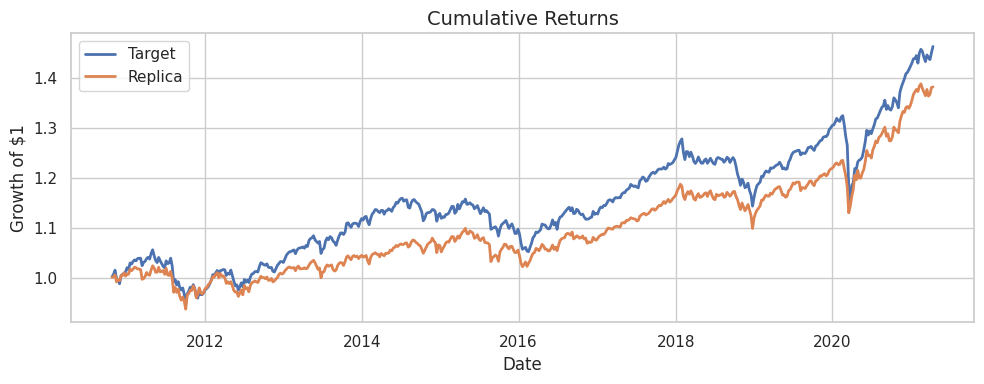

--- DRAWDOWN ---


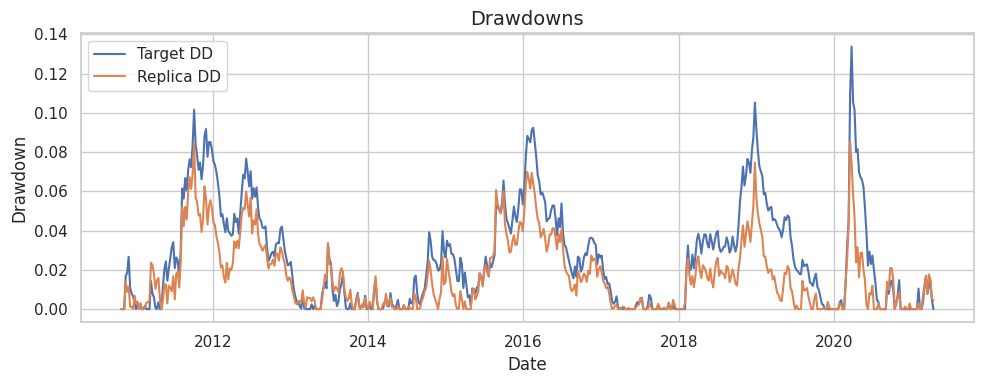

--- WEIGHTS ---


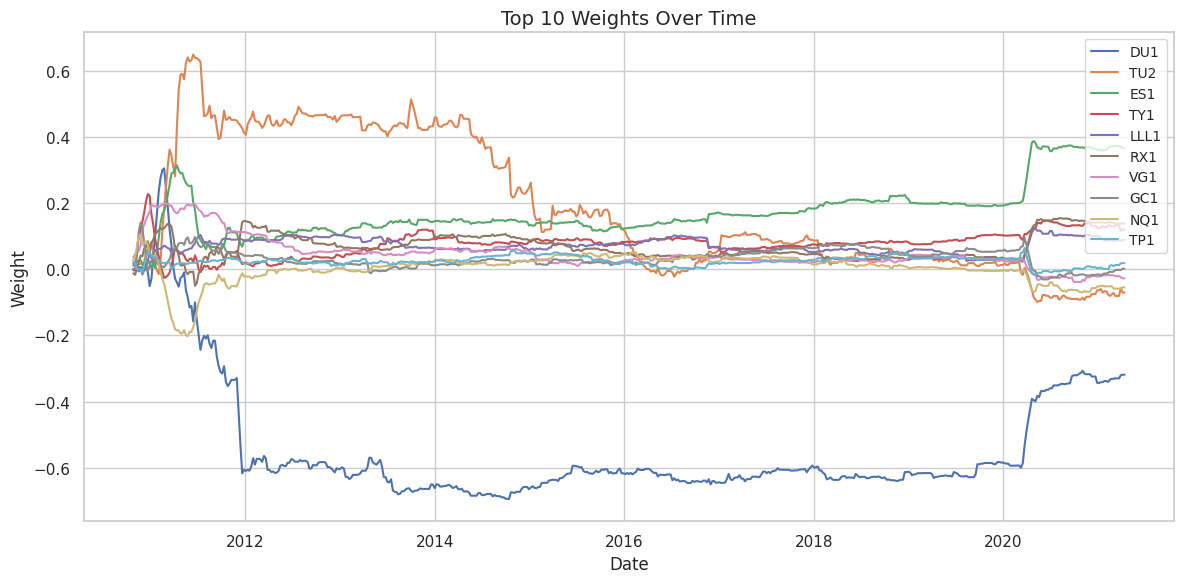

--- EXPOSURES ---


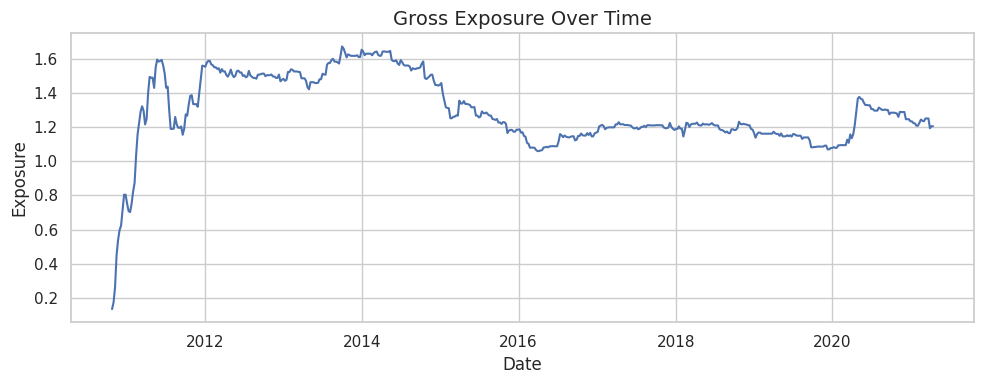

--- COSTS ---


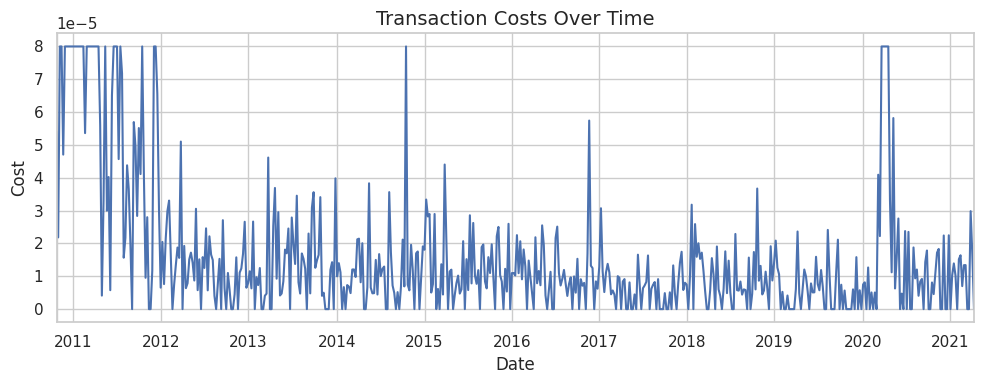

--- CONSTRAINTS ---


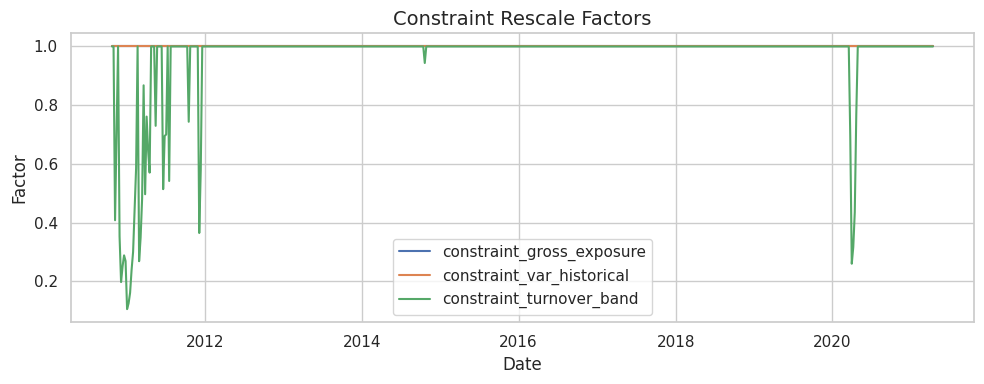

In [98]:
experiment_config = {
    # === Model Selection ===
    "model_name": "kalman",
    "model_params": {

        # Kalman-specific
        "trans_cov": 1e-5,
        "obs_cov": 1e-5,
        "init_scale": 1.0,
        "init_with_regression": True,
        "regressor_cls": ElasticNet,
        "regressor_params": {
            "alpha": 0.01,
            "l1_ratio": 0.0,
        },

        # Regressor-specific
        "alpha":    0.01,
        "l1_ratio": 0.0
    },

    # === Preprocessing ===
    "scaler_name": "standard",

    # === Dataset ===
    "X": X,
    "y": y,

    # === Backtest Settings ===
    "split_strategy": "sliding",
    "window":          156,
    "step":            1,

    # === Constraints ===
    "constraint_funcs": [
        constraint_gross_exposure,
        constraint_var_historical,
        constraint_turnover_band
    ],
    "constraint_params": {
        "constraint_gross_exposure": {},
        "constraint_var_historical": {},
        "constraint_turnover_band": {"min_turnover": 0.01, "max_turnover": 0.2}
    },

    # === Transaction Costs ===
    "transaction_cost_rate": 4*1e-4,

    # === Logging ===
    "verbose":          False,
    "save_model":       False,
    "model_save_path":  None
}

result = run_single_backtest_experiment(experiment_config)
disp = BacktestDisplay(result)
disp.show_all()

# TEST

# PUSH

In [ ]:
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

In [ ]:
from getpass import getpass
import os

# 1. Get your GitHub Personal Access Token securely
token = getpass("Paste your GitHub Personal Access Token: ")
os.environ['GITHUB_TOKEN'] = token

# 2. Set your GitHub repo details
GITHUB_USERNAME = "jacopo-raffaeli"
REPO_NAME = "portfolio-replica"
BRANCH = "main"

# 3. Construct remote URL with token embedded (hidden from output)
remote_url = f"https://{token}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"

# 4. Set git user info (if not done already)
!git config --global user.email "jacoporaffaeli@gmail.com"
!git config --global user.name "jacopo-raffaeli"

# 5. Change remote origin URL to token-embedded one
!git remote set-url origin {remote_url}


Paste your GitHub Personal Access Token: ··········


In [ ]:
# 6. Add and commit changes (customize your commit message)
!git add .
!git commit -m "feat: Add Initial EDA" || echo "No changes to commit."

# 7. Push to GitHub
!git push origin {BRANCH}

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
No changes to commit.
Everything up-to-date


In [ ]:
# Show git status, which files are changed and staged
!git status

# Show last commit files changed (to check if notebook was included)
!git show --name-only --oneline -1

# Show current branch
!git branch

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
f00faf2 (HEAD -> main, origin/main, origin/HEAD) Created using Colab
notebooks/01_Exploratory_Data_Analysis.ipynb
* main
